# Model Experimentation

In [35]:
# Change directory to keep paths consistent
%cd /Users/brk/projects/masters/SU/ergo/src

/Users/brk/projects/masters/SU/ergo/src


In [36]:
# minimise me
%load_ext autoreload
%autoreload 2
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import ipywidgets as widgets
import datetime
from ipywidgets import interact, interactive, fixed, interact_manual
import pandas as pd
import numpy as np
import models
import vis
import common
import read
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import sklearn
import tqdm
import logging as l
import tqdm
import yaml
import glob
from matplotlib.colors import LogNorm
import re
from sklearn.metrics import classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in the training data

In [37]:
(
    X_trn, X_val, y_trn, y_val, dt_trn, dt_val
) = common.read_and_split_from_npz("../gesture_data/trn_20_10.npz")

## Regular FFNN model

Fitting model
Checking fit of X, y
Checking model params: X.shape=(144703, 20, 30) y.shape=(144703,) X_val.shape=(36176, 20, 30) y_val.shape=(36176,)
Numbers of classes:
y: [141243     99     98     97     80     78     77     75     74     73
     72     65     64     63     62     61     60     59     58     57],
y_val: [35311    25    24    20    19    18    17    16    15    14]
g255=50, allowlist=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Shapes after allowlist: X.shape=(144703, 20, 30) y.shape=(144703,) X_val.shape=(36176, 20, 30) y_val.shape=(36176,)
to_i is the identity, to_g is the identity, g255=50
g2i: y [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24,

2023-10-08 14:44:39.688843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-08 14:44:39.706823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Compiling model
Fitting model
Epoch 1/30
 10/877 [..............................] - ETA: 5s - loss: 6.8115   

2023-10-08 14:44:49.198472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


877/877 [==============================] - ETA: 0s - loss: 1.0131

2023-10-08 14:44:53.502999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/brk/projects/masters/SU/ergo/src/vis.py:142: RuntimeWarning: invalid value encountered in divide
  mask=(cm == 0),


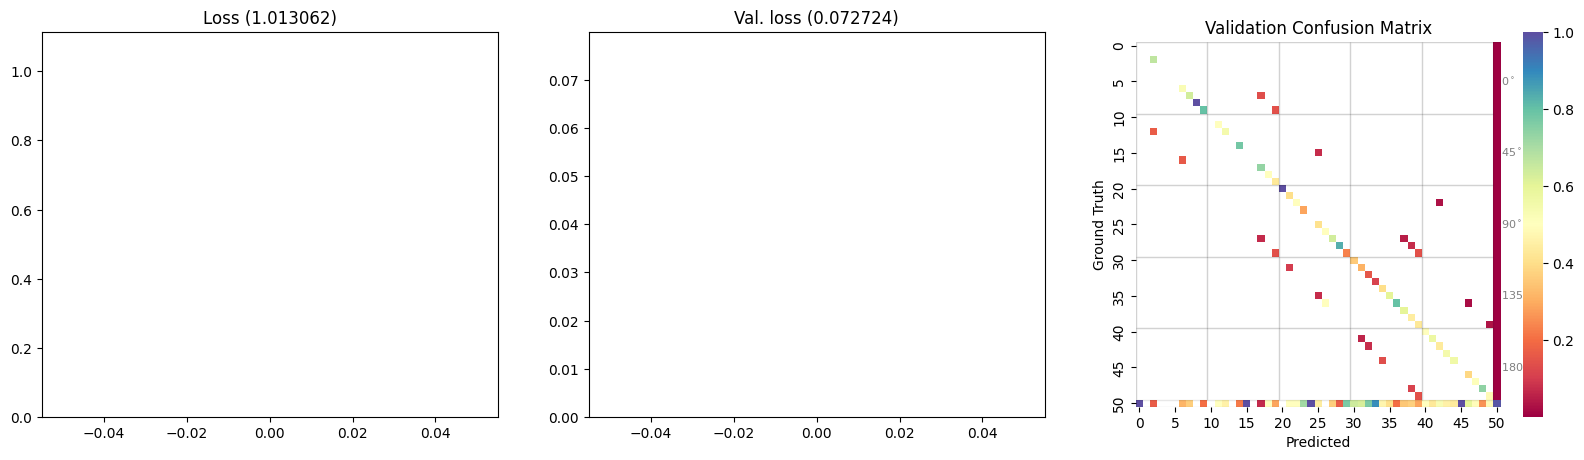

877/877 [==============================] - 6s 7ms/step - loss: 1.0131 - val_loss: 0.0727
Epoch 2/30
868/877 [============================>.] - ETA: 0s - loss: 0.4074

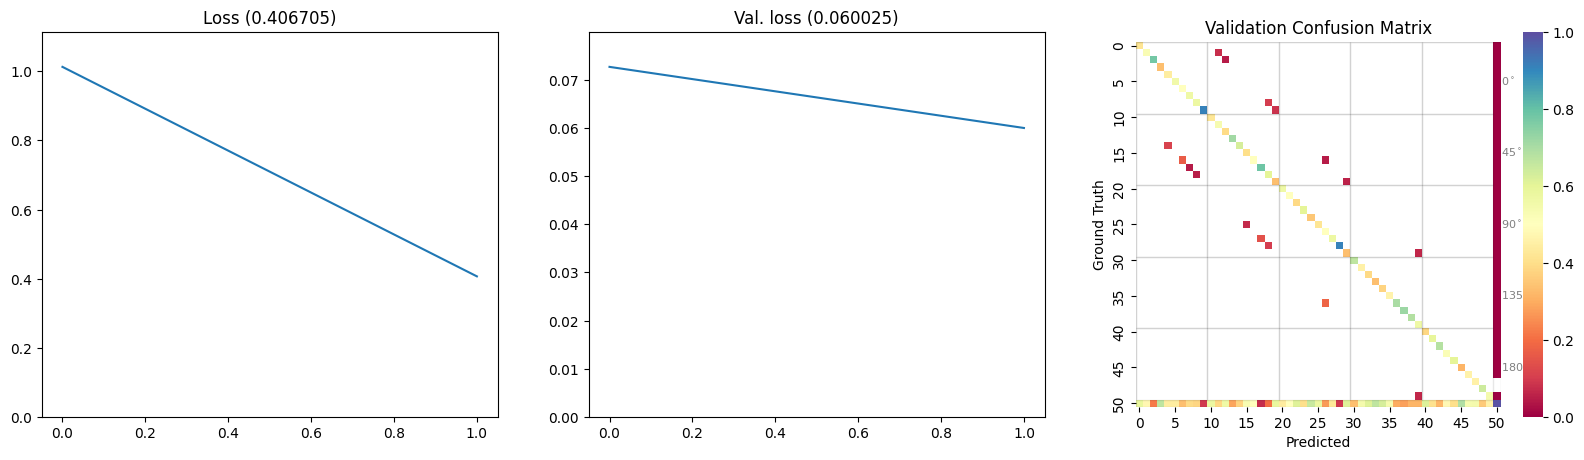

877/877 [==============================] - 5s 5ms/step - loss: 0.4067 - val_loss: 0.0600
Epoch 3/30
872/877 [============================>.] - ETA: 0s - loss: 0.3120

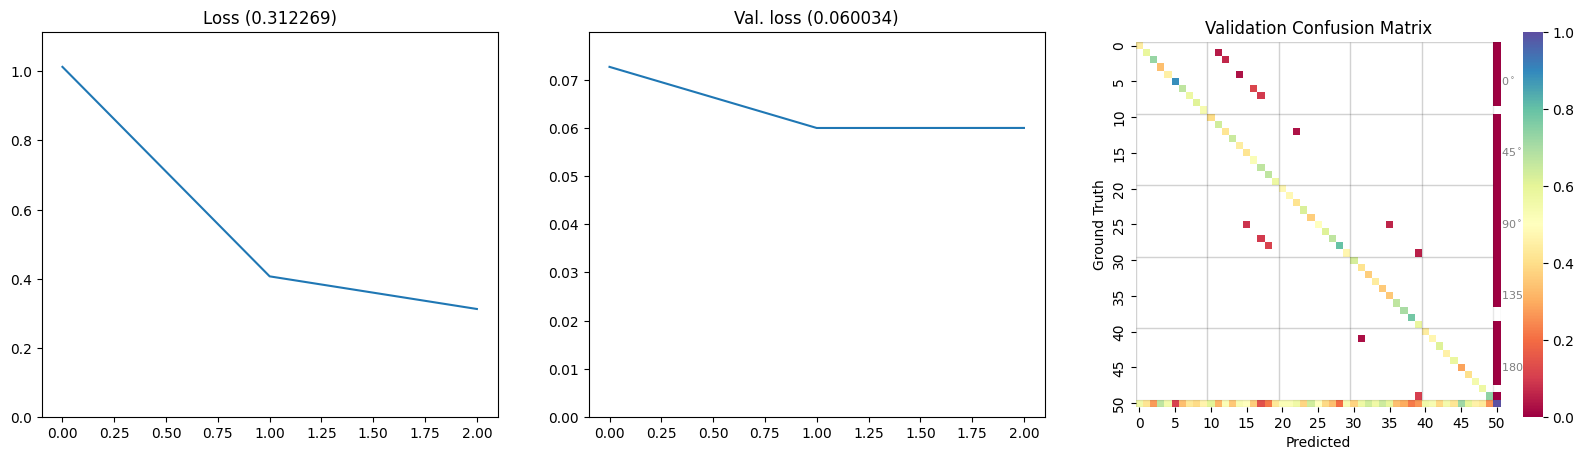

877/877 [==============================] - 5s 5ms/step - loss: 0.3123 - val_loss: 0.0600
Epoch 4/30
874/877 [============================>.] - ETA: 0s - loss: 0.2701

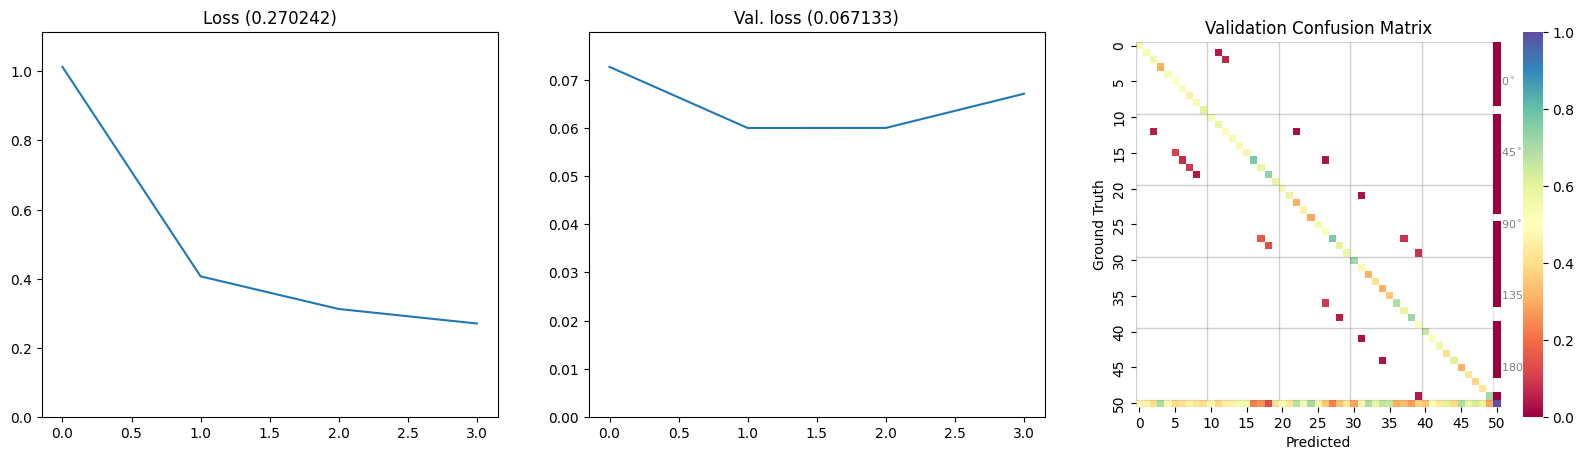

877/877 [==============================] - 5s 5ms/step - loss: 0.2702 - val_loss: 0.0671
Epoch 5/30
871/877 [============================>.] - ETA: 0s - loss: 0.2398

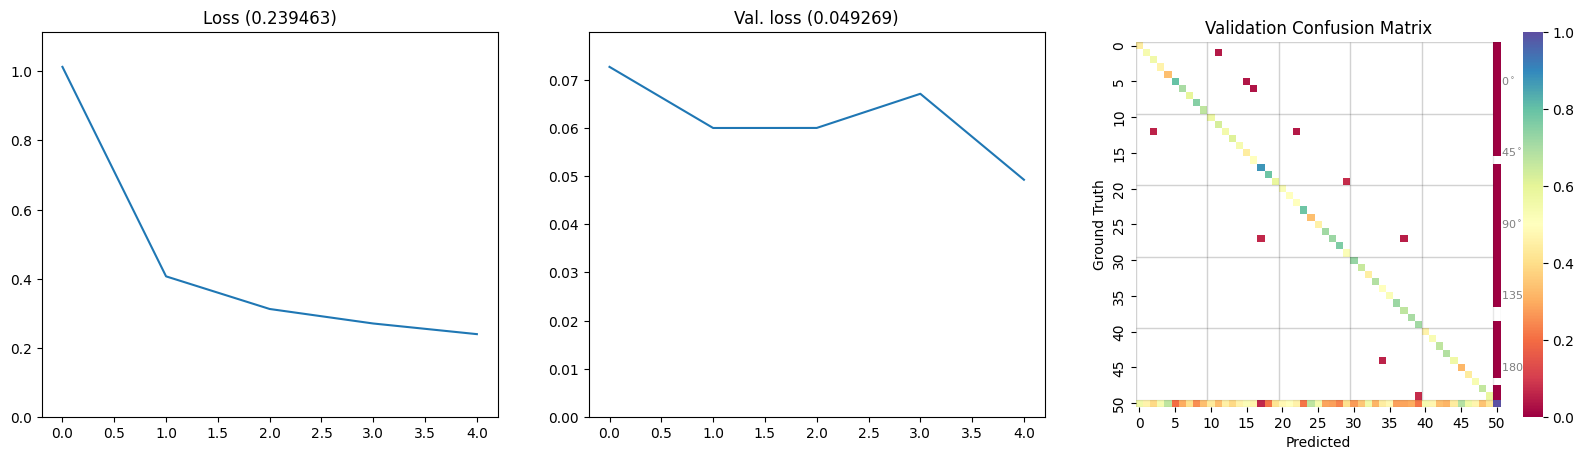

877/877 [==============================] - 4s 5ms/step - loss: 0.2395 - val_loss: 0.0493
Epoch 6/30
870/877 [============================>.] - ETA: 0s - loss: 0.2205

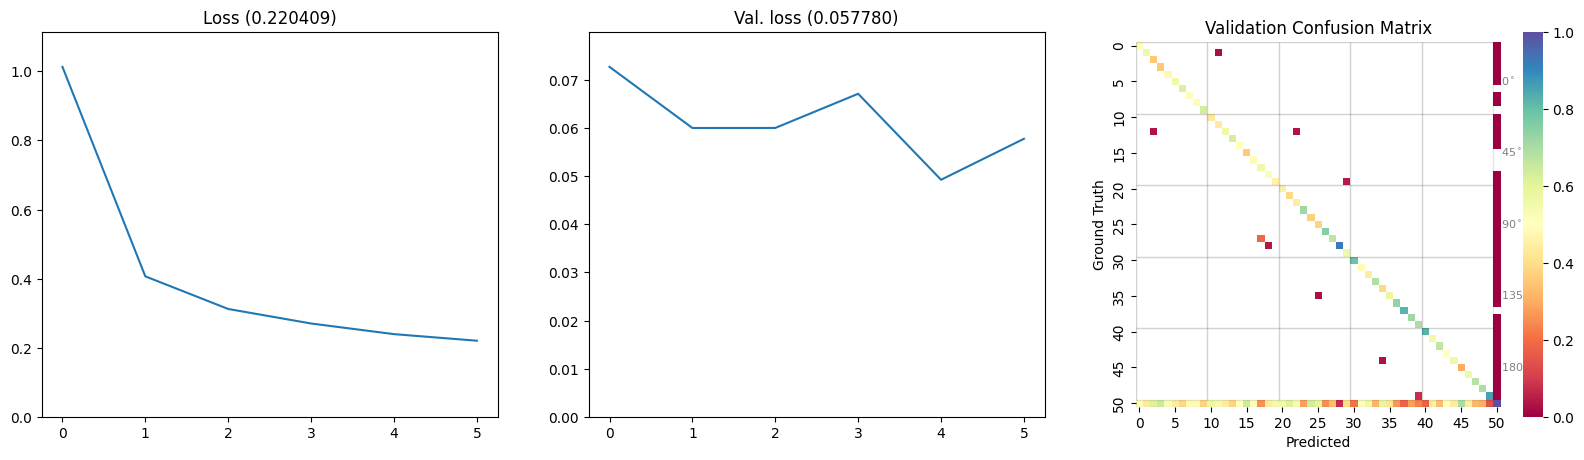

877/877 [==============================] - 4s 5ms/step - loss: 0.2204 - val_loss: 0.0578
Epoch 7/30
871/877 [============================>.] - ETA: 0s - loss: 0.1977

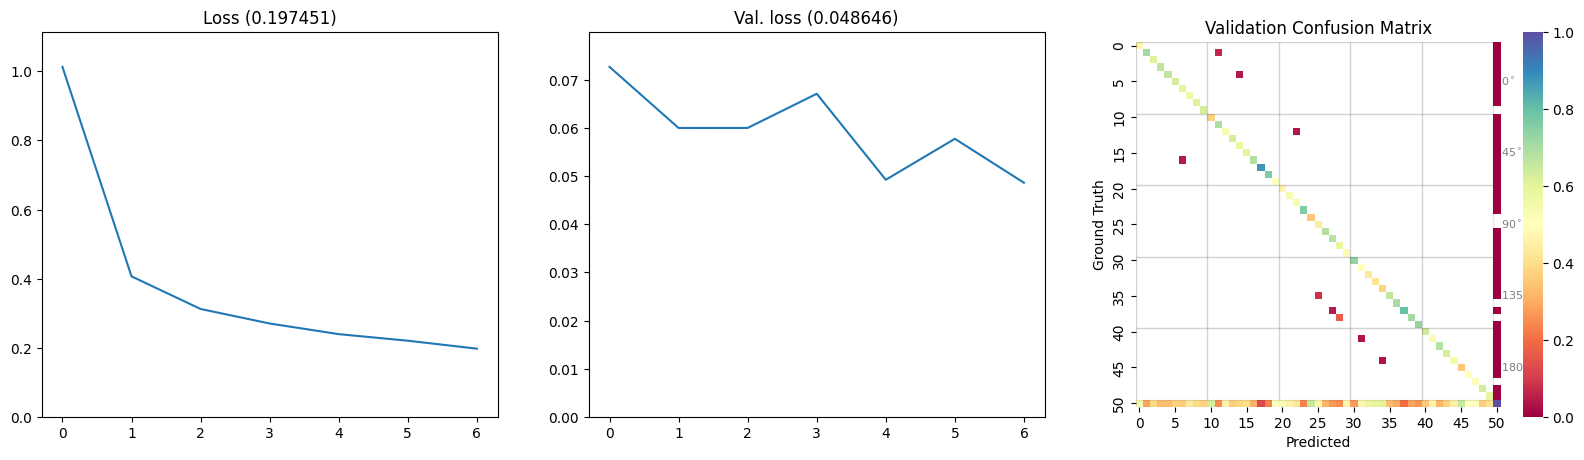

877/877 [==============================] - 4s 5ms/step - loss: 0.1975 - val_loss: 0.0486
Epoch 8/30
868/877 [============================>.] - ETA: 0s - loss: 0.1894

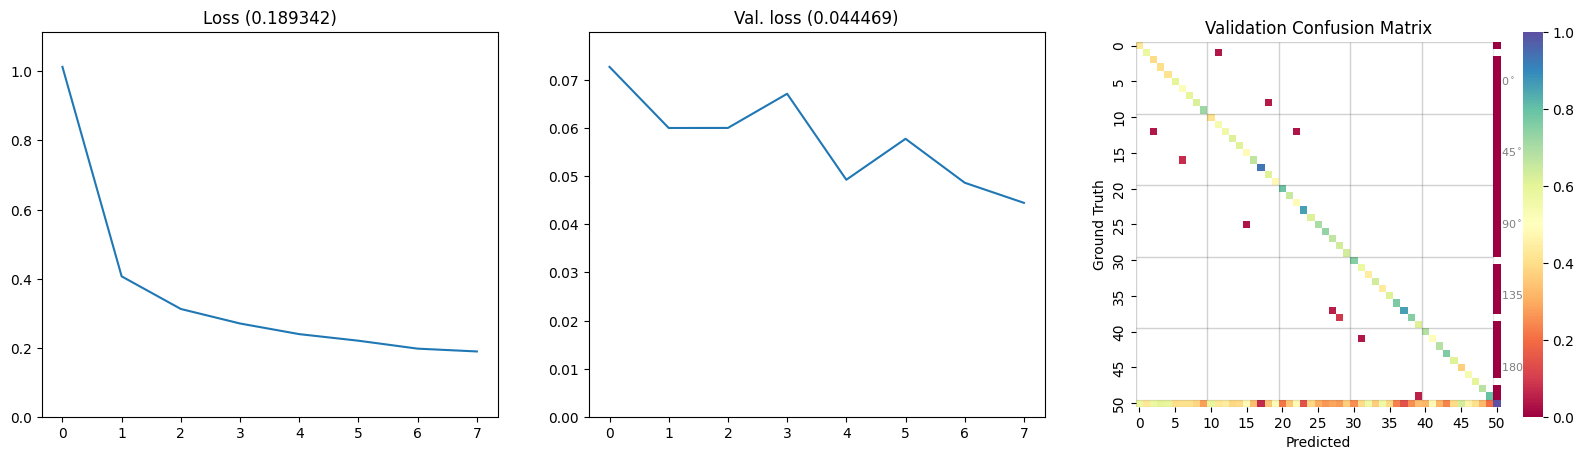

877/877 [==============================] - 5s 5ms/step - loss: 0.1893 - val_loss: 0.0445
Epoch 9/30
872/877 [============================>.] - ETA: 0s - loss: 0.1791

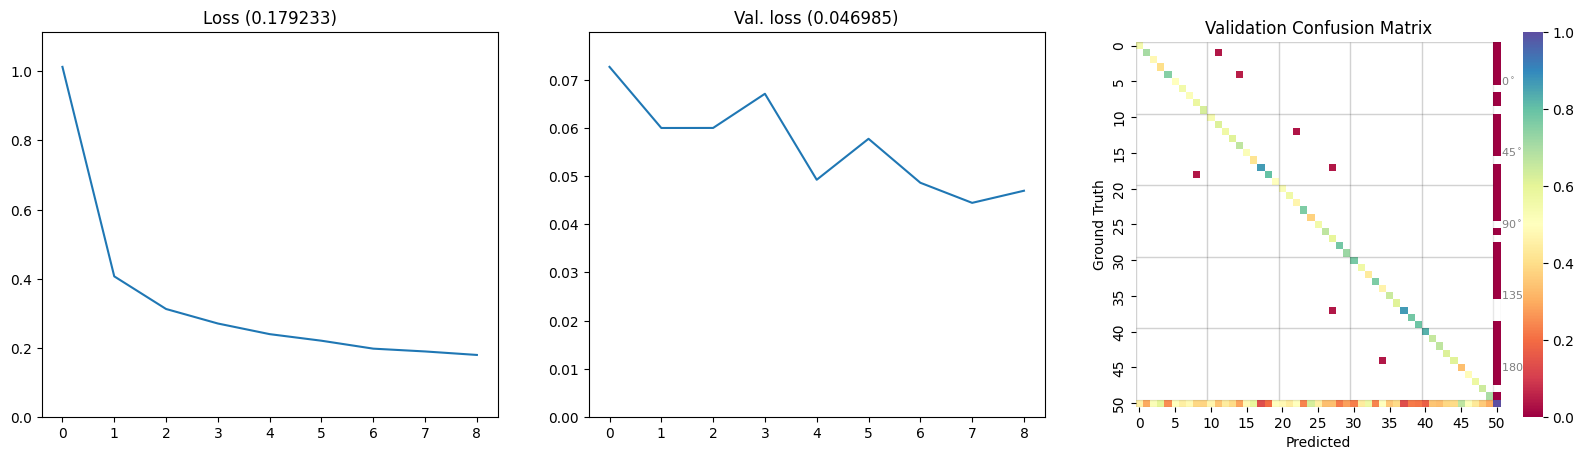

877/877 [==============================] - 5s 5ms/step - loss: 0.1792 - val_loss: 0.0470
Epoch 10/30
877/877 [==============================] - ETA: 0s - loss: 0.1641

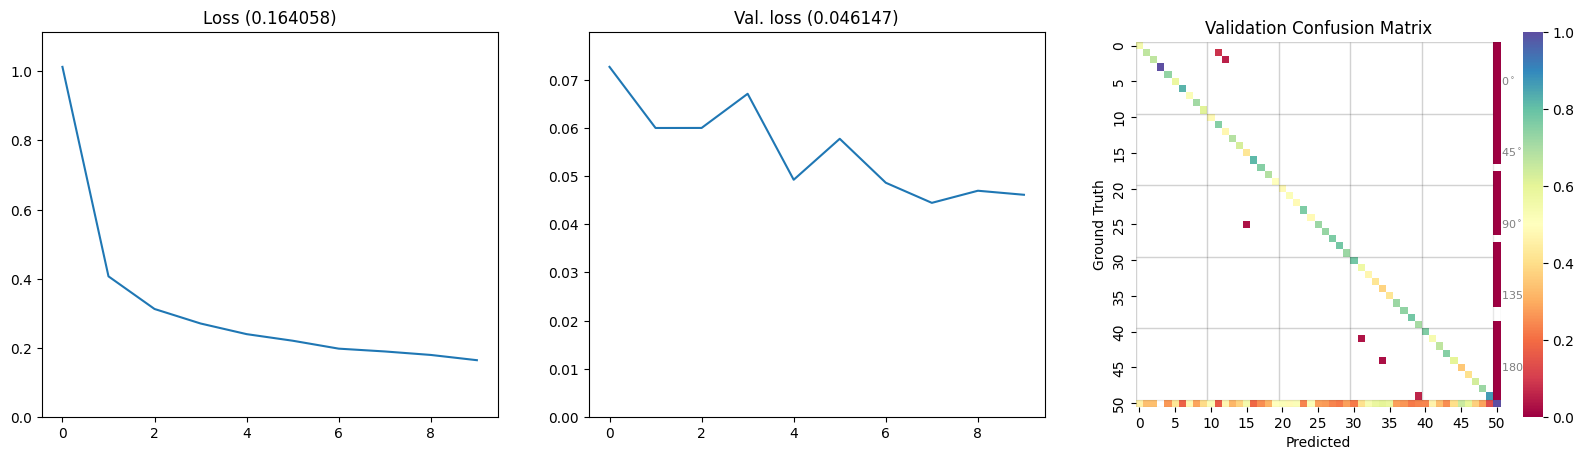

877/877 [==============================] - 5s 5ms/step - loss: 0.1641 - val_loss: 0.0461
Epoch 11/30
875/877 [============================>.] - ETA: 0s - loss: 0.1628

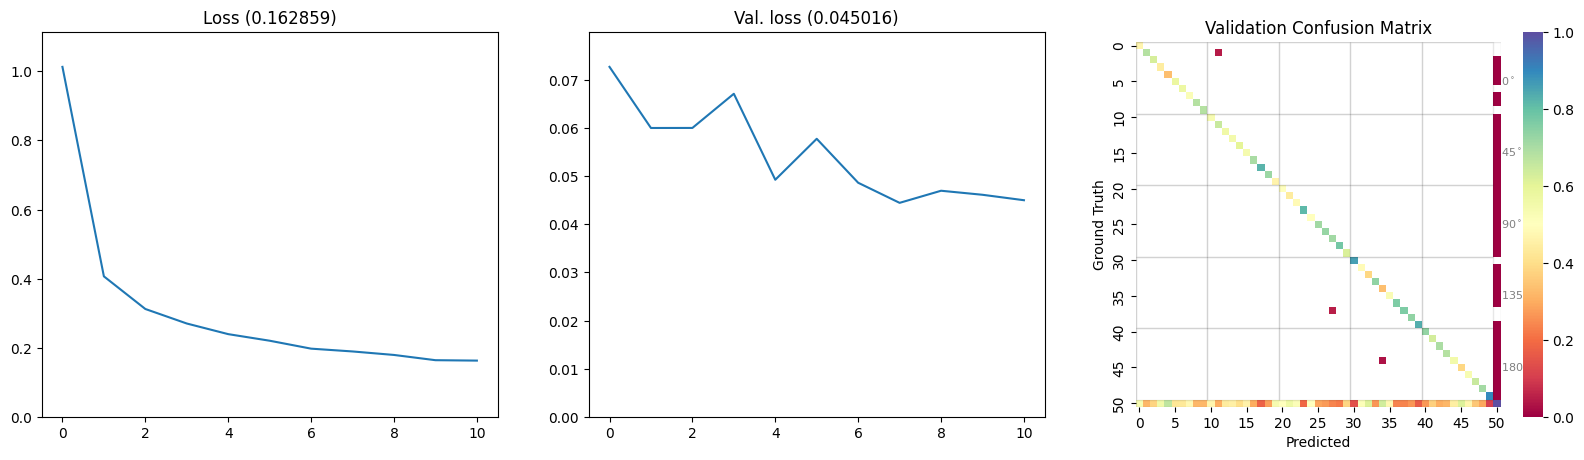

877/877 [==============================] - 5s 5ms/step - loss: 0.1629 - val_loss: 0.0450
Epoch 12/30
867/877 [============================>.] - ETA: 0s - loss: 0.1527

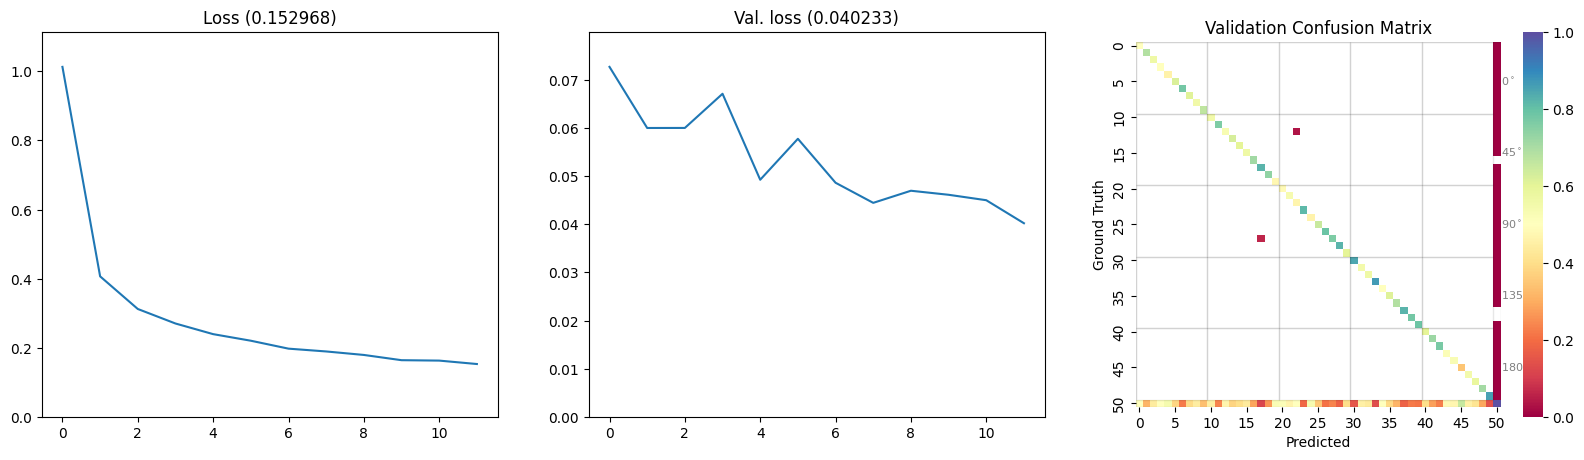

877/877 [==============================] - 5s 5ms/step - loss: 0.1530 - val_loss: 0.0402
Epoch 13/30
868/877 [============================>.] - ETA: 0s - loss: 0.1472

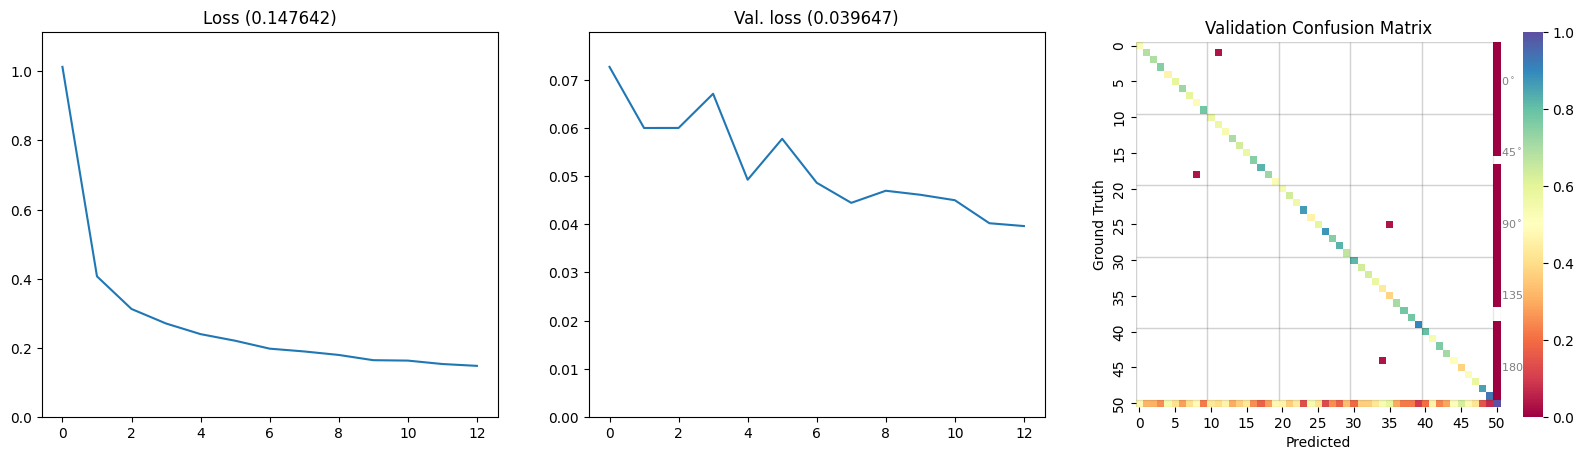

877/877 [==============================] - 5s 5ms/step - loss: 0.1476 - val_loss: 0.0396
Epoch 14/30
873/877 [============================>.] - ETA: 0s - loss: 0.1423

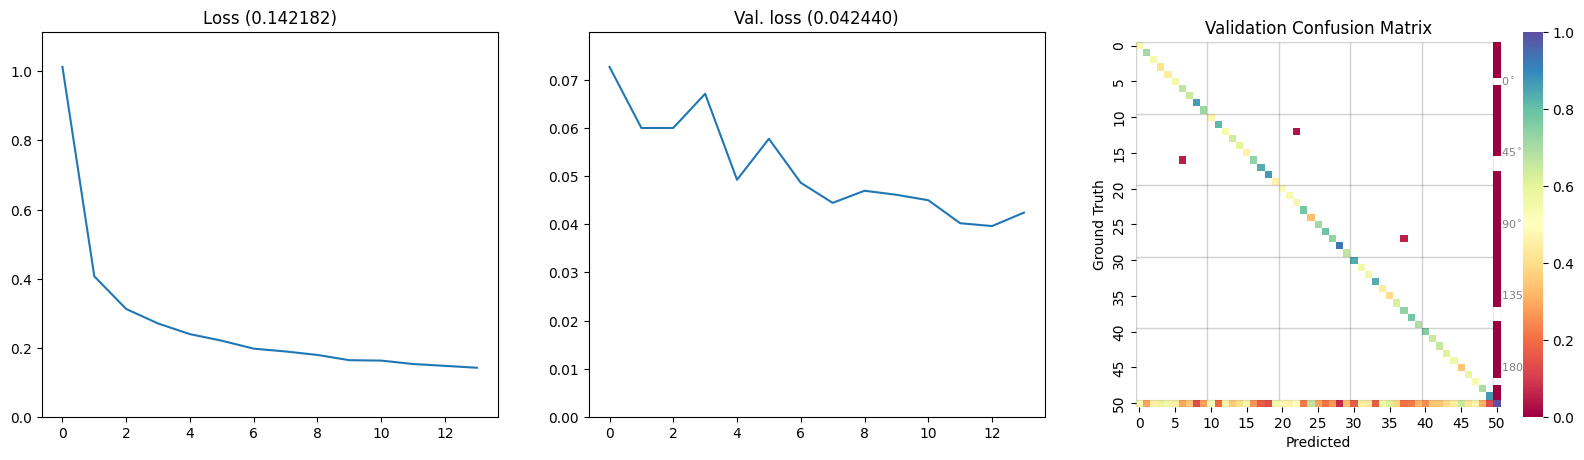

877/877 [==============================] - 5s 5ms/step - loss: 0.1422 - val_loss: 0.0424
Epoch 15/30
875/877 [============================>.] - ETA: 0s - loss: 0.1375

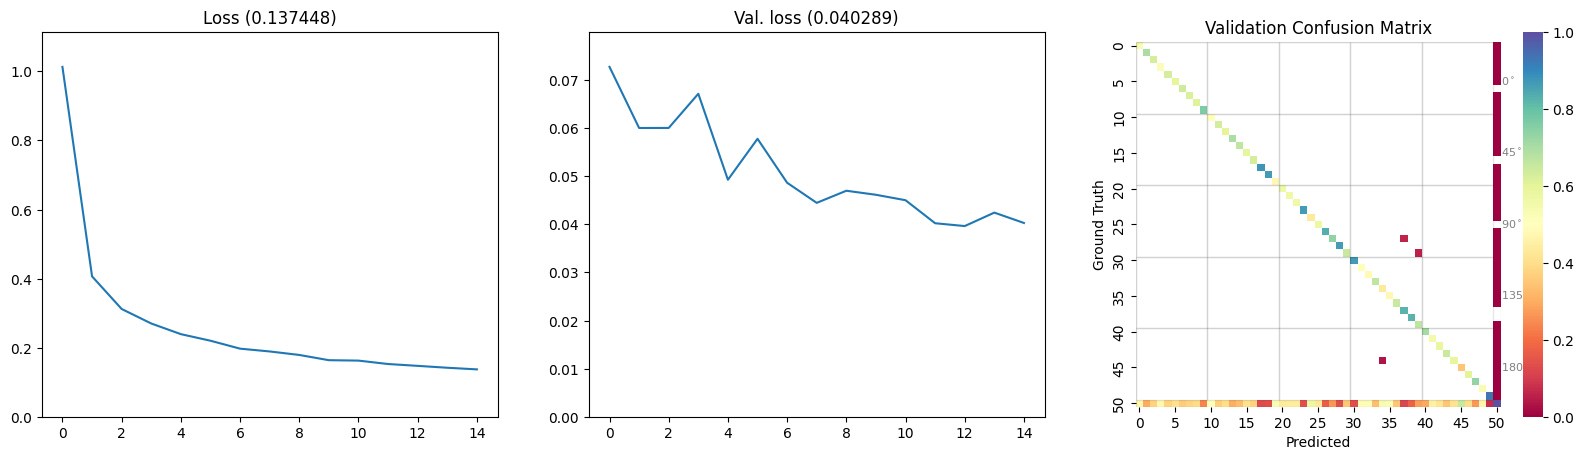

877/877 [==============================] - 5s 5ms/step - loss: 0.1374 - val_loss: 0.0403
Epoch 16/30
866/877 [============================>.] - ETA: 0s - loss: 0.1313

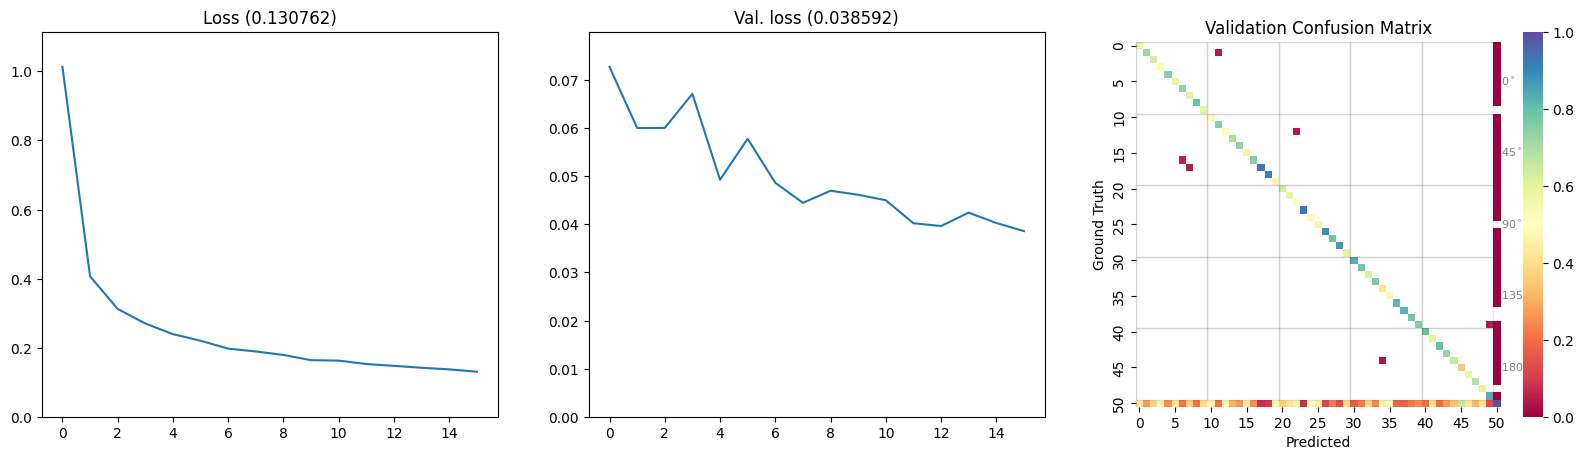

877/877 [==============================] - 5s 5ms/step - loss: 0.1308 - val_loss: 0.0386
Epoch 17/30
873/877 [============================>.] - ETA: 0s - loss: 0.1284

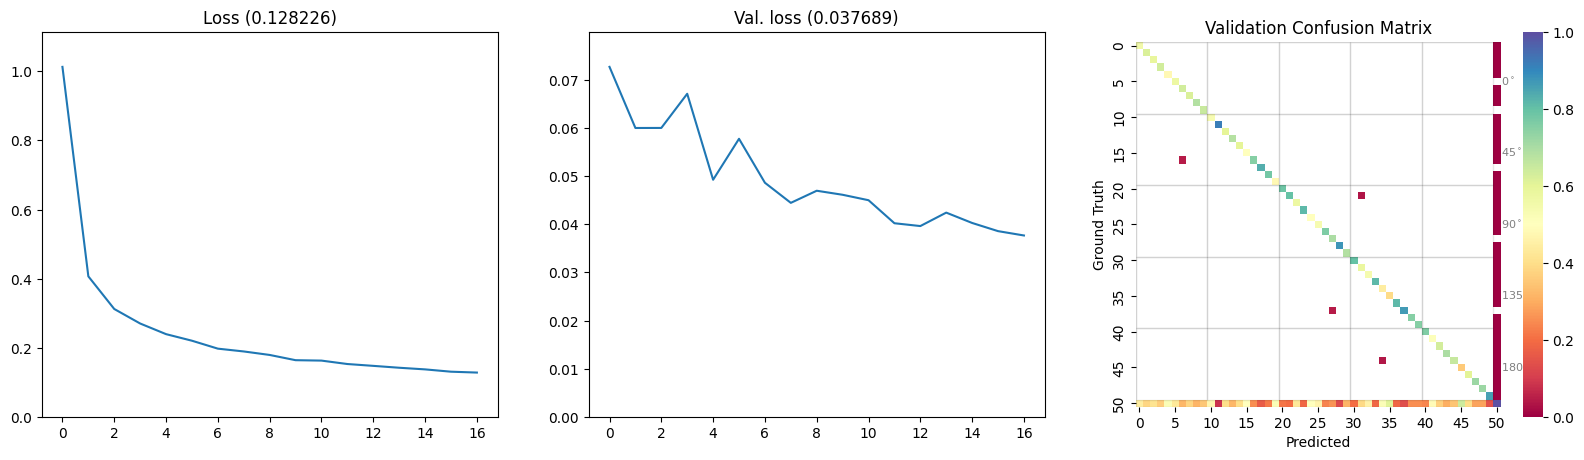

877/877 [==============================] - 5s 5ms/step - loss: 0.1282 - val_loss: 0.0377
Epoch 18/30
866/877 [============================>.] - ETA: 0s - loss: 0.1229

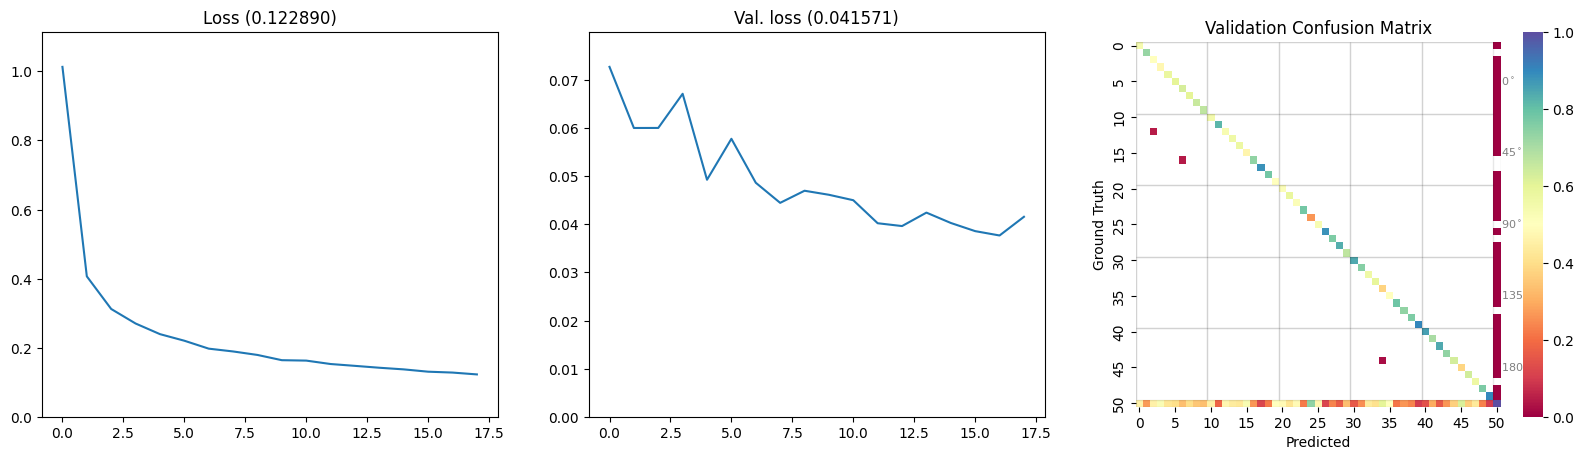

877/877 [==============================] - 5s 5ms/step - loss: 0.1229 - val_loss: 0.0416
Epoch 19/30
867/877 [============================>.] - ETA: 0s - loss: 0.1199

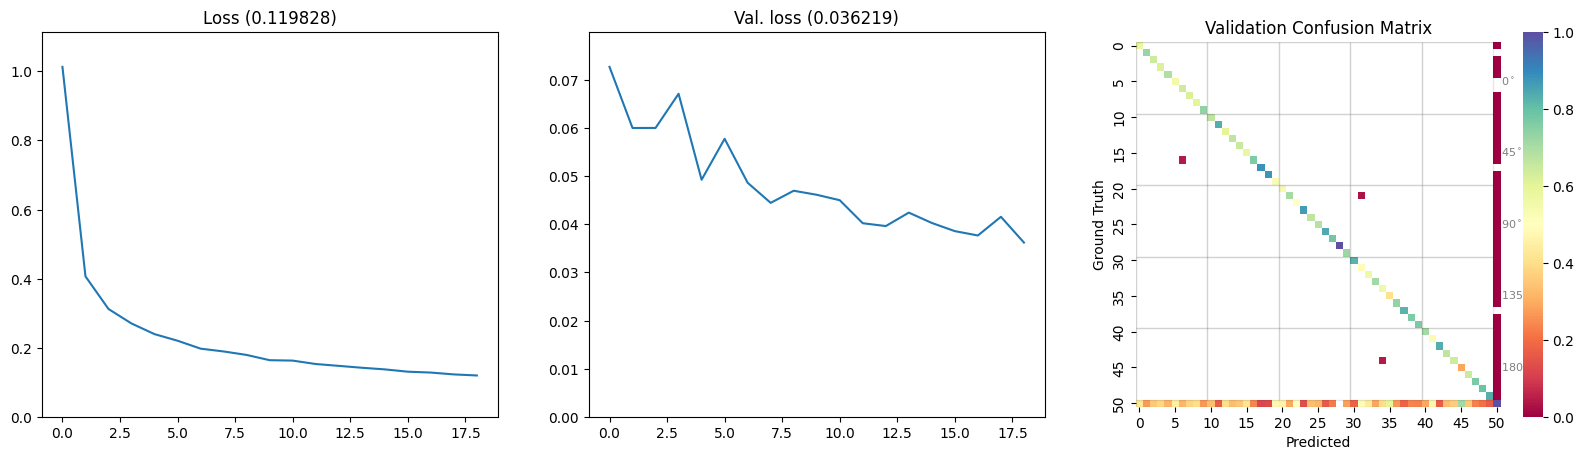

877/877 [==============================] - 5s 5ms/step - loss: 0.1198 - val_loss: 0.0362
Epoch 20/30
876/877 [============================>.] - ETA: 0s - loss: 0.1163

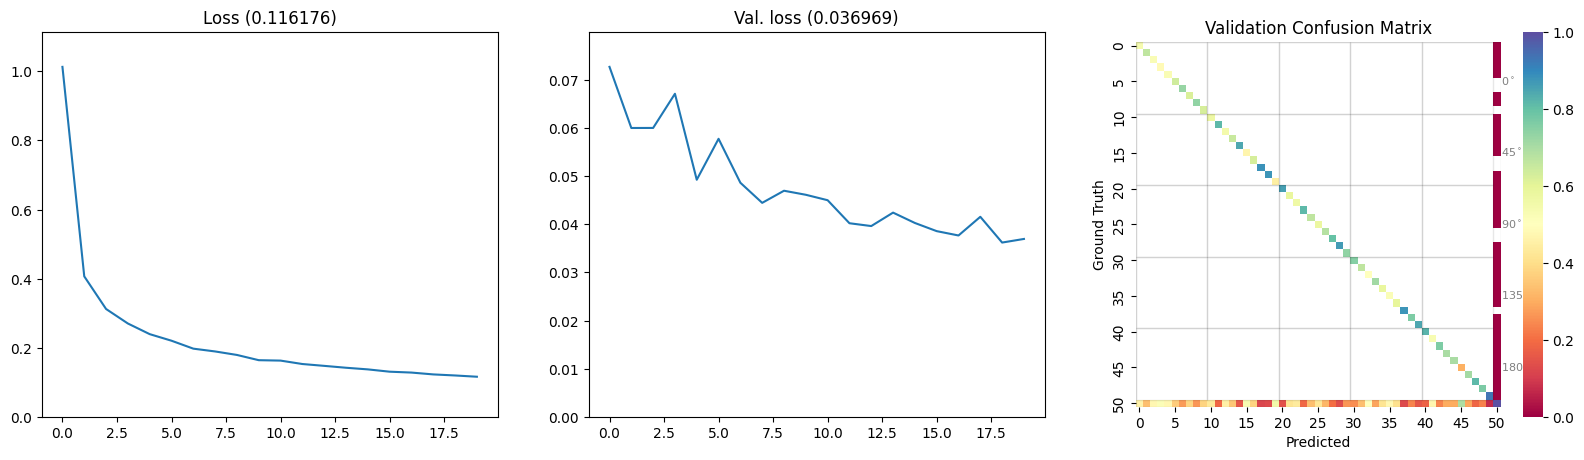

877/877 [==============================] - 4s 5ms/step - loss: 0.1162 - val_loss: 0.0370
Epoch 21/30
869/877 [============================>.] - ETA: 0s - loss: 0.1119

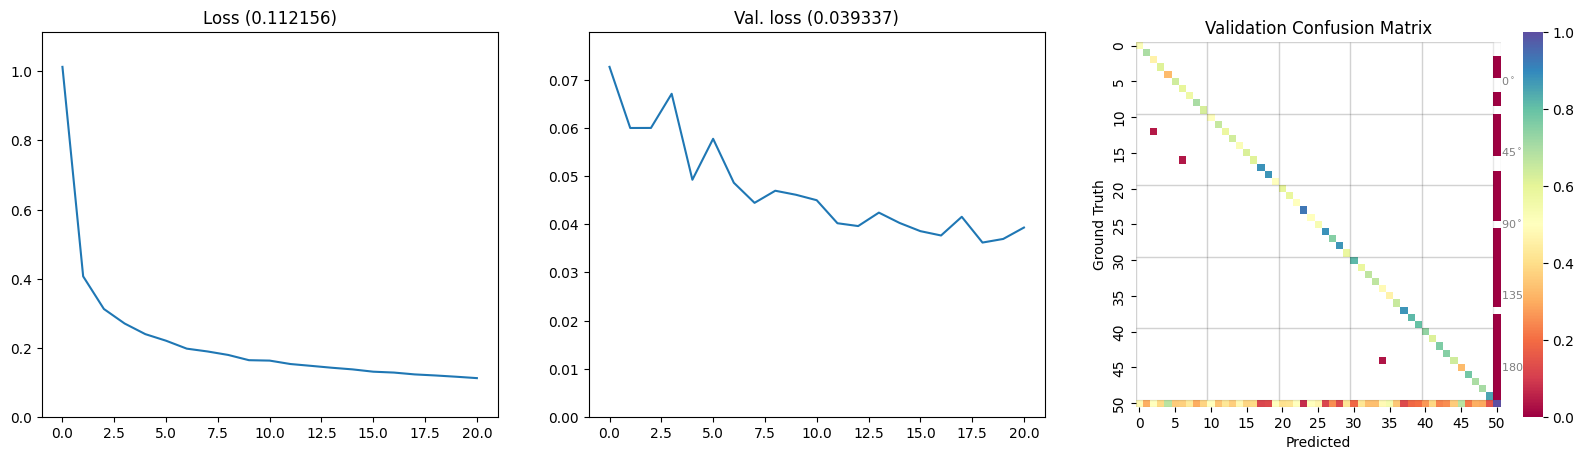

877/877 [==============================] - 5s 5ms/step - loss: 0.1122 - val_loss: 0.0393
Epoch 22/30
866/877 [============================>.] - ETA: 0s - loss: 0.1117

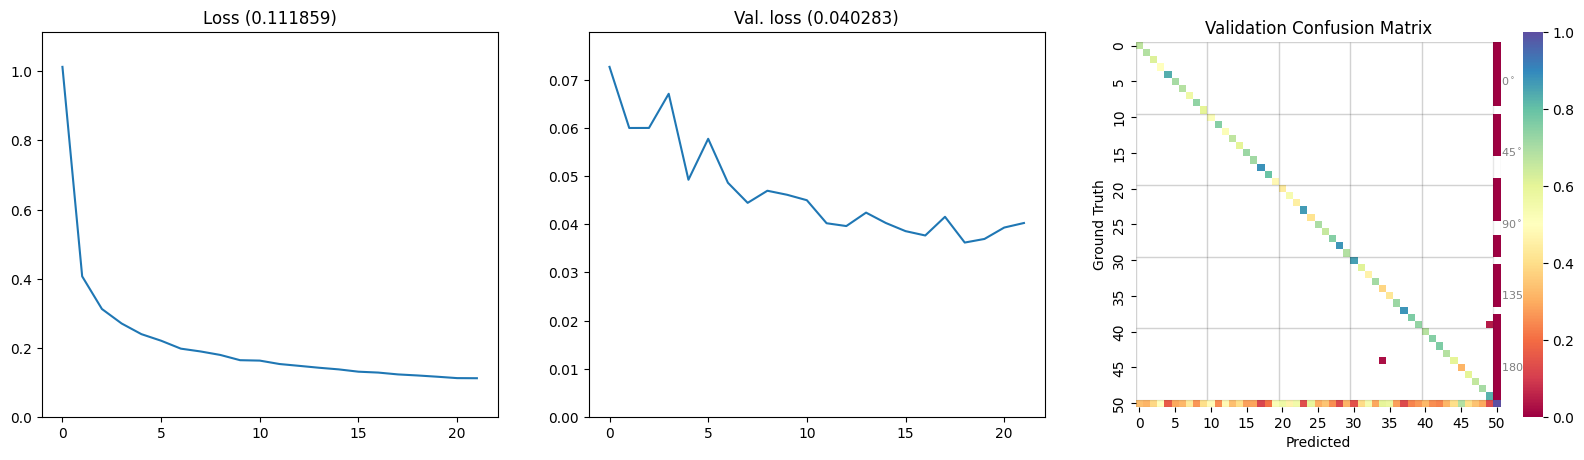

877/877 [==============================] - 4s 5ms/step - loss: 0.1119 - val_loss: 0.0403
Epoch 23/30
876/877 [============================>.] - ETA: 0s - loss: 0.1079

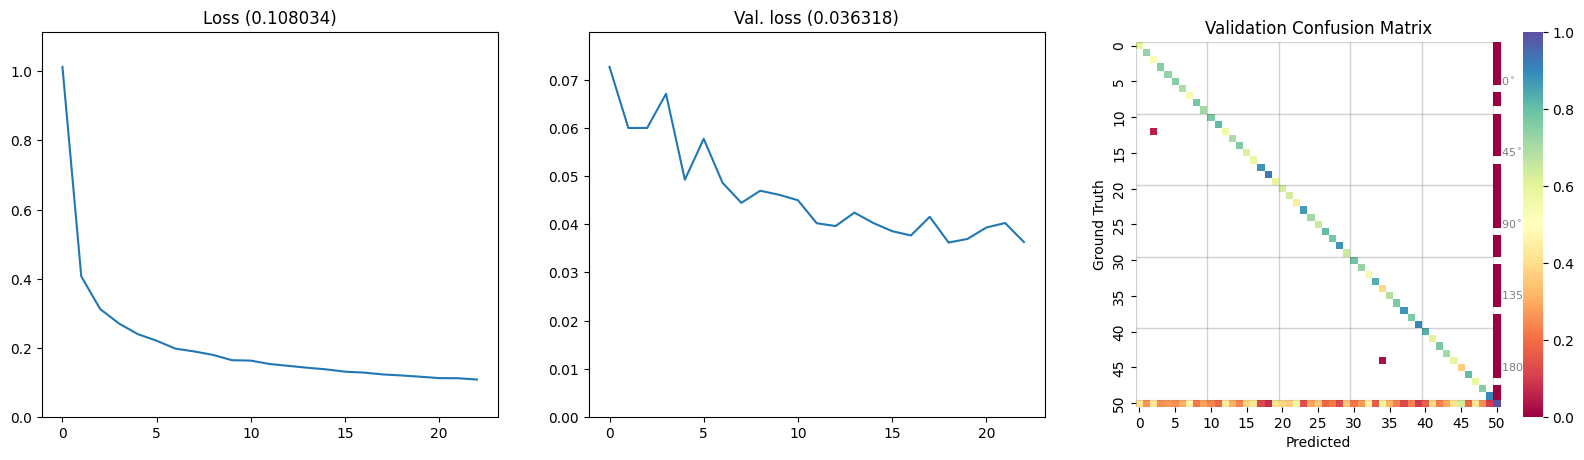

877/877 [==============================] - 4s 5ms/step - loss: 0.1080 - val_loss: 0.0363
Epoch 24/30
870/877 [============================>.] - ETA: 0s - loss: 0.1052

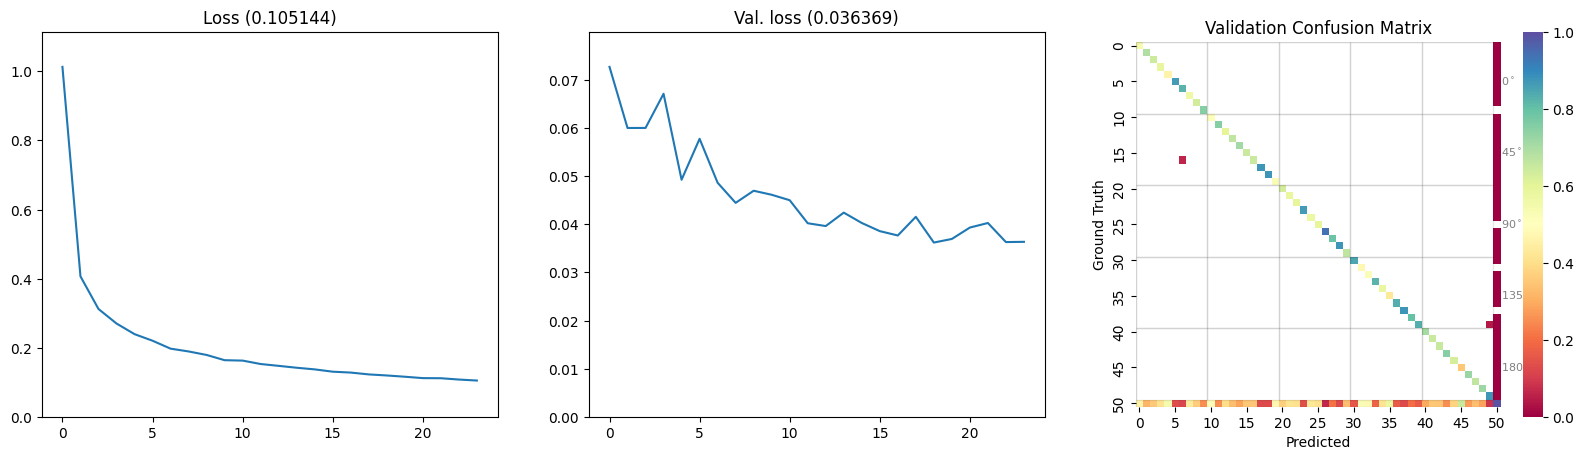

877/877 [==============================] - 5s 6ms/step - loss: 0.1051 - val_loss: 0.0364
Epoch 25/30
875/877 [============================>.] - ETA: 0s - loss: 0.1027

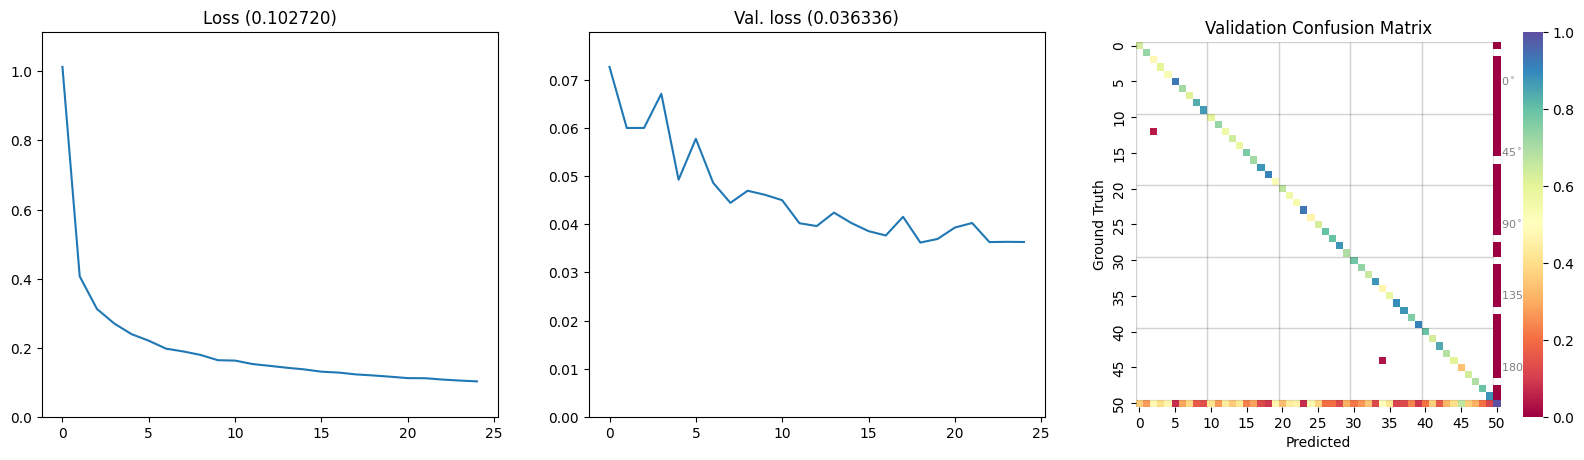

877/877 [==============================] - 5s 5ms/step - loss: 0.1027 - val_loss: 0.0363
Epoch 26/30
875/877 [============================>.] - ETA: 0s - loss: 0.1014

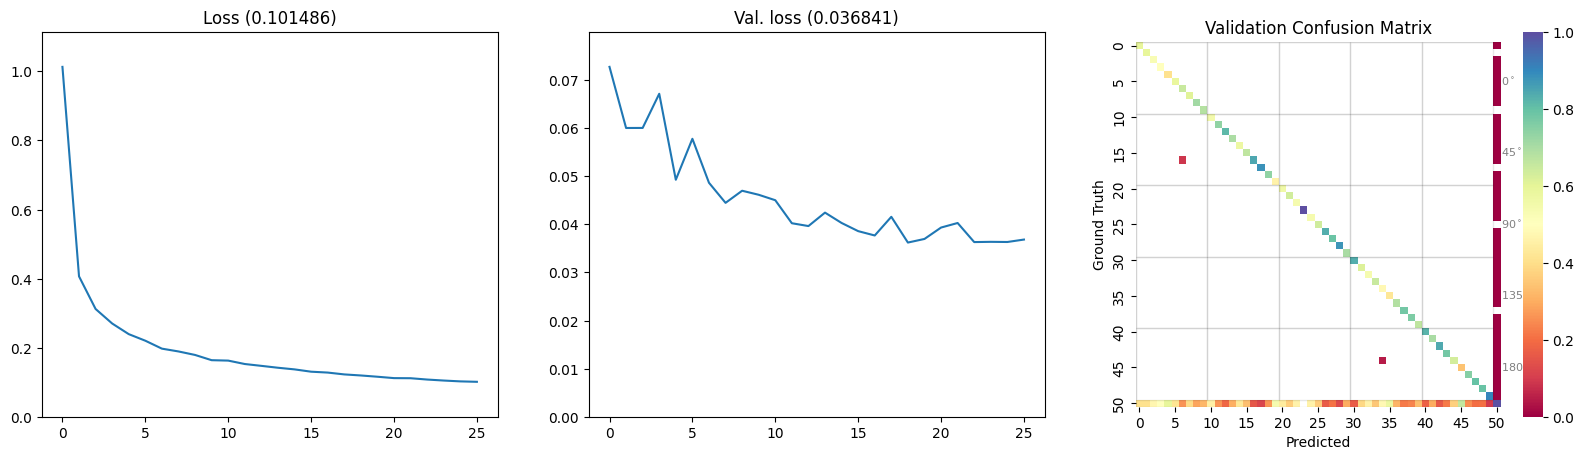

877/877 [==============================] - 5s 5ms/step - loss: 0.1015 - val_loss: 0.0368
Epoch 27/30
869/877 [============================>.] - ETA: 0s - loss: 0.0969

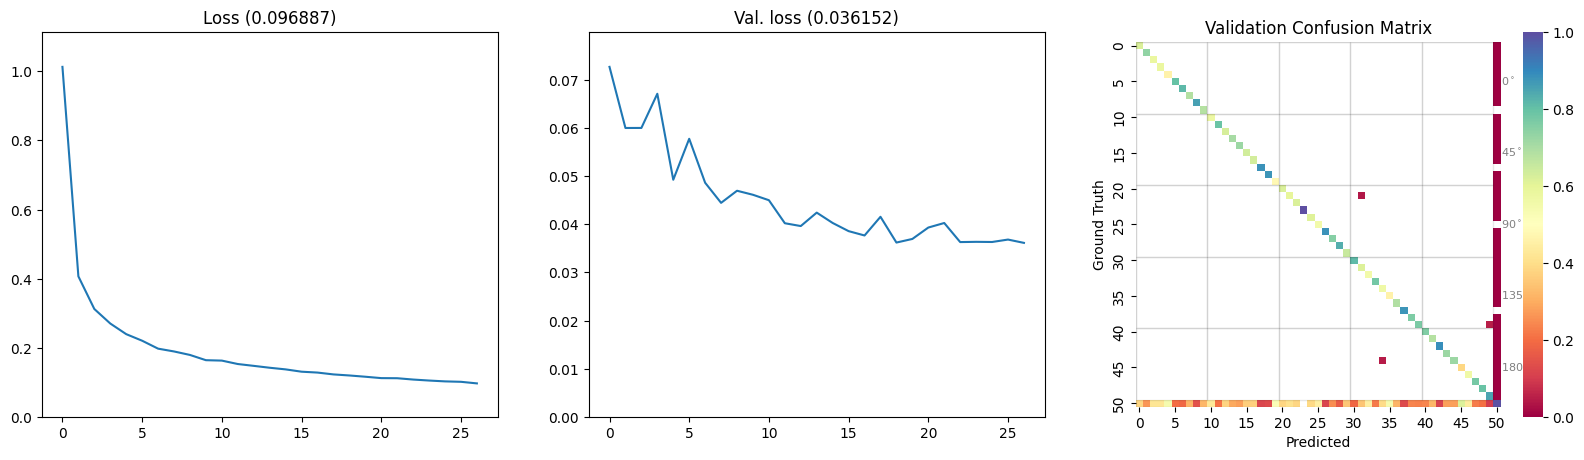

877/877 [==============================] - 5s 5ms/step - loss: 0.0969 - val_loss: 0.0362
Epoch 28/30
875/877 [============================>.] - ETA: 0s - loss: 0.0956

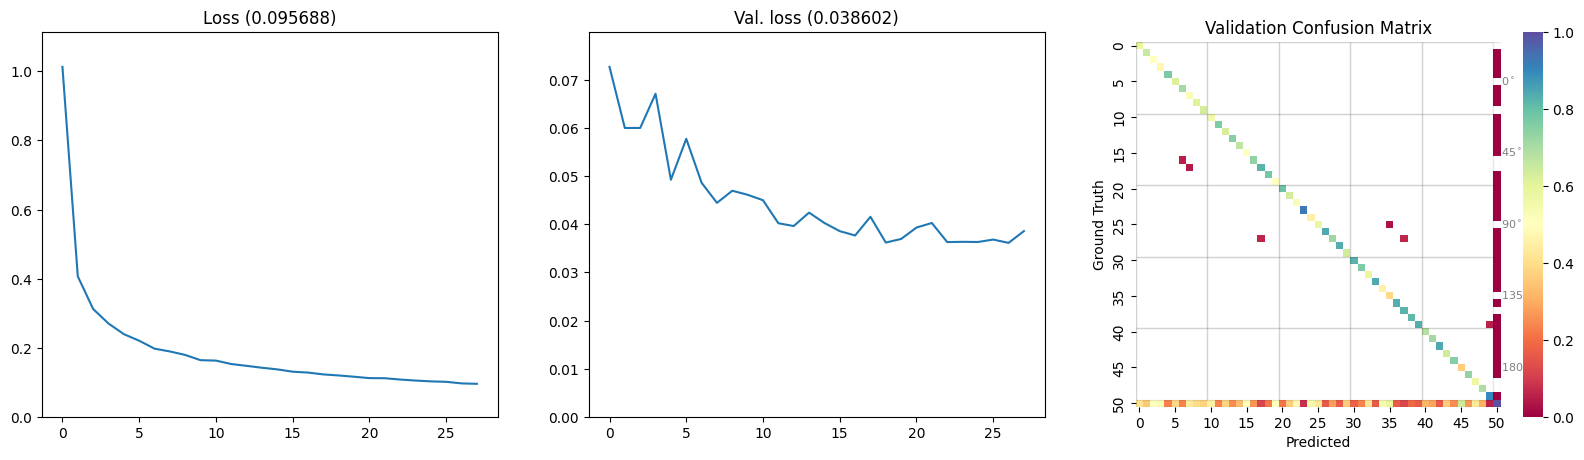

877/877 [==============================] - 5s 5ms/step - loss: 0.0957 - val_loss: 0.0386
Epoch 29/30
868/877 [============================>.] - ETA: 0s - loss: 0.0942

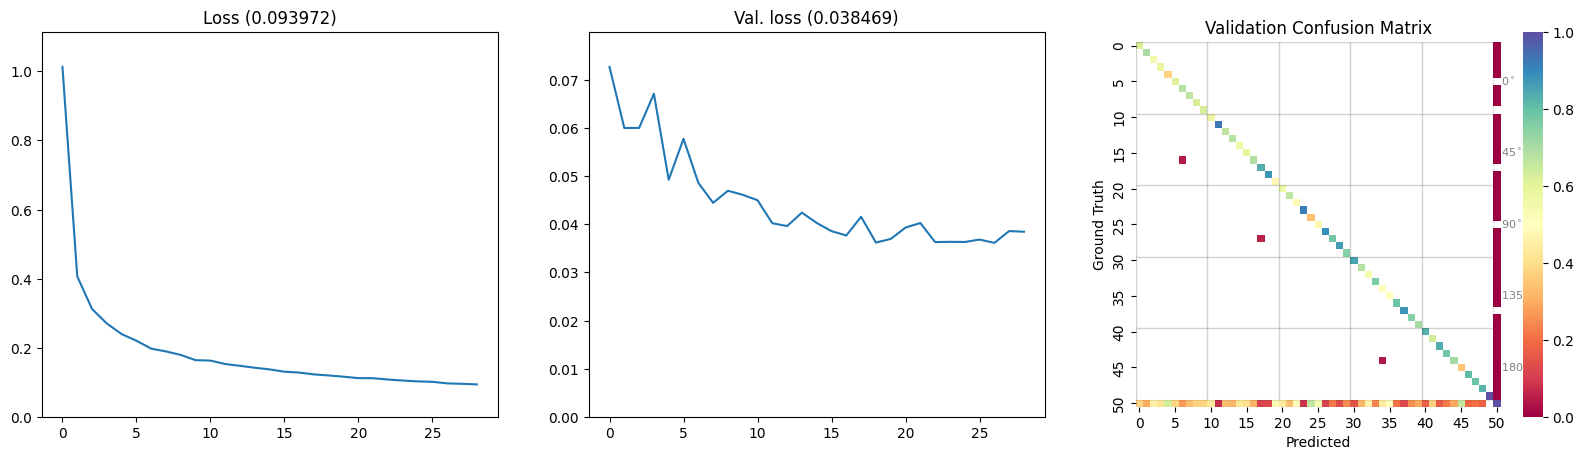

877/877 [==============================] - 5s 5ms/step - loss: 0.0940 - val_loss: 0.0385
Epoch 30/30
877/877 [==============================] - ETA: 0s - loss: 0.0920

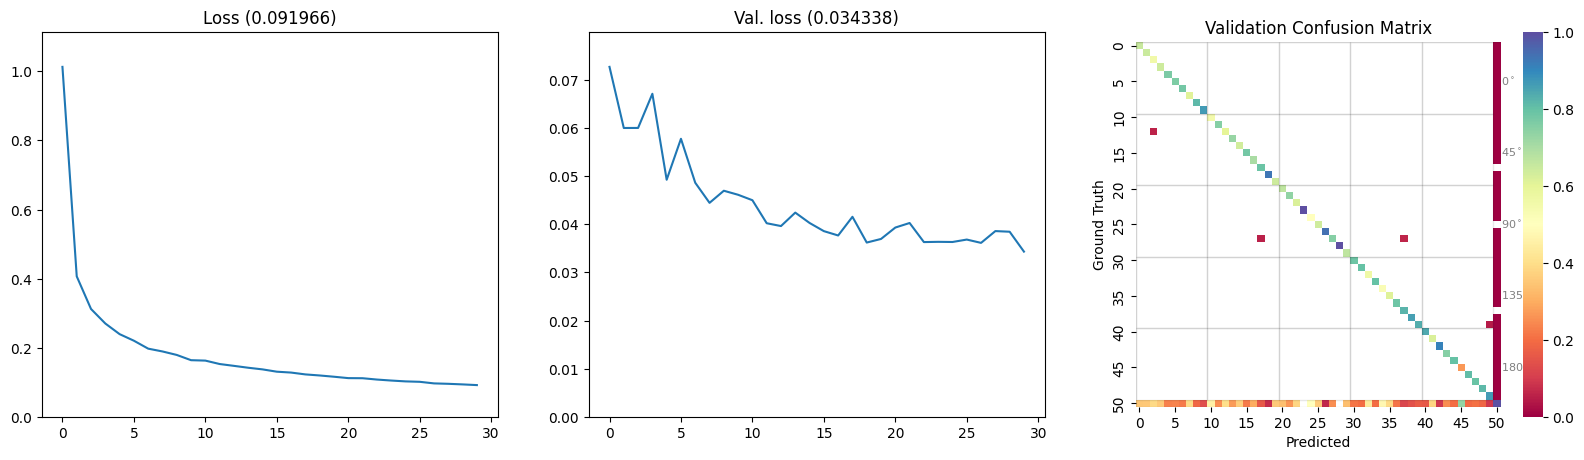

877/877 [==============================] - 5s 5ms/step - loss: 0.0920 - val_loss: 0.0343


In [42]:
# ffnn.dropout_rate         2.686140e-01
# ffnn.l2_coefficient       4.091000e-07
# ffnn.nodes_per_layer.1    1.830000e+02
# ffnn.nodes_per_layer.2             NaN
# ffnn.nodes_per_layer.3             NaN
# nn.batch_size             1.650000e+02
# nn.learning_rate          2.931719e-04
keras.backend.clear_session()
num_layers = 1
nodes_per_layer = [183]
model_type = "FFNN"
num_gesture_classes = 51
preprocessing: models.PreprocessingConfig = {
    'seed': 42 + 4,
    'n_timesteps': 20,
    'max_obs_per_class': 200 if model_type == "HMM" else None,
    'gesture_allowlist': list(range(num_gesture_classes)),
    'num_gesture_classes': num_gesture_classes,
    'rep_num': 0
}


config: models.ConfigDict = {
    "model_type": "FFNN",
    "preprocessing": preprocessing,
    "nn": {
        "epochs": 30,
        "batch_size": 165,
        "learning_rate": 0.00029317194404026507,
        "optimizer": "adam",
    },
    "ffnn": {
        "nodes_per_layer": nodes_per_layer,
        "l2_coefficient":4.0913308867412863e-07,
        "dropout_rate": 0.2686144169702842,
    },
    "cusum": None,
    "lstm": None,
    "hmm": None,
}
# pprint(config)
clf = models.FFNNClassifier(config=config)
print("Fitting model")
start = datetime.datetime.now()
                                                                                       
clf.fit(
    X_trn,
    y_trn,
    dt_trn,
    validation_data=(X_val, y_val, dt_val),
    verbose=True,
    callbacks=[
        models.DisplayConfMat(
            validation_data=(X_val, y_val, dt_val),
            conf_mat=False,
#             fig_path=f'saved_models/{study_name}/trial_{trial.number}.png',
        ),
#         keras.callbacks.ReduceLROnPlateau(
#             monitor="val_loss", factor=0.2, patience=5
#         ),
    ]
)
finsh = datetime.datetime.now()
# score = calc_metrics(trial, start, finsh, clf)


### Calculate metrics for the FFNN model

duration_ms 149300.418
val_loss 0.034337740391492844
trn_loss 0.09196582436561584
[2023-10-08 14:47:07.903658] Predicting trn with X.shape = (144703, 20, 30)
[2023-10-08 14:47:08.944608] Saving y_pred and y_true
[2023-10-08 14:47:08.947515] Getting classification report
[2023-10-08 14:47:09.049223] Predicting val with X.shape = (36176, 20, 30)
[2023-10-08 14:47:09.128629] Saving y_pred and y_true
[2023-10-08 14:47:09.129396] Getting classification report
[2023-10-08 14:47:09.154159] Saving data to jsonlines ../saved_models/results_ffnn_optuna.jsonl
[2023-10-08 14:47:09.160091] Dumping model config to saved_models/ffnn_2023-10-08T14:47:07.901649/config.yaml
saved_models/ffnn_2023-10-08T14:47:07.901649
Dump[saved_models/ffnn_2023-10-08T14:47:07.901649]: Saving model
Dump[saved_models/ffnn_2023-10-08T14:47:07.901649]: Saving training data
Dump[saved_models/ffnn_2023-10-08T14:47:07.901649]: Saving validation data
Dump[saved_models/ffnn_2023-10-08T14:47:07.901649]: Saving config
Dump[saved_

<AxesSubplot:xlabel='Predicted', ylabel='Ground Truth'>

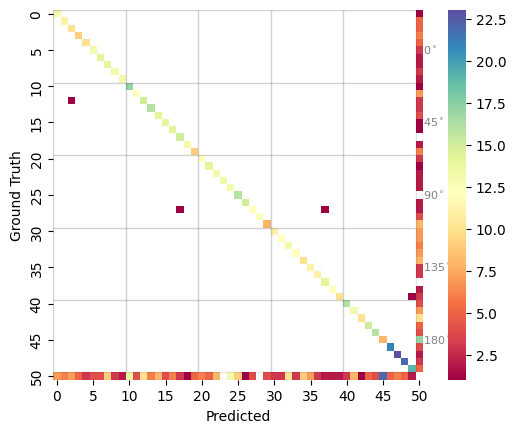

In [43]:
model_type = clf.config['model_type']
X_val = clf.validation_data[0]
y_val = clf.validation_data[1]
duration = finsh - start
duration_ms = duration.seconds * 1000 + duration.microseconds / 1000
print("duration_ms", duration_ms)
                                                                         
if model_type == "FFNN":
    print("val_loss", clf.history.history["val_loss"][-1])
    print("trn_loss", clf.history.history["loss"][-1])
                                                                         
jsonl_path = f"../saved_models/results_{model_type.lower()}_optuna.jsonl"
model_dir = clf.write_as_jsonl(jsonl_path)
if model_type == "FFNN":
    print(model_dir)
    clf.dump(model_dir)
                                                                         
print("model_dir", model_dir)
                                                                         
y_pred = clf.predict(X_val)
clf_report = pd.json_normalize(sklearn.metrics.classification_report(
    y_val.astype(int),
    y_pred.astype(int),
    output_dict=True,
    zero_division=0,
))
print(sklearn.metrics.classification_report(
    y_val.astype(int),
    y_pred.astype(int),
    output_dict=False,
    zero_division=0,
))
                                                                      
print("val.macro avg.f1-score", clf_report['macro avg.f1-score'].values[0])
print("val.macro avg.precision", clf_report['macro avg.precision'].values[0])
print("val.macro avg.recall", clf_report['macro avg.recall'].values[0])
print (clf_report['macro avg.f1-score'].values[0])

cm = tf.math.confusion_matrix(y_val, y_pred, num_classes=51).numpy()
cm[-1, -1] = 0
vis.conf_mat(
    cm,
    norm=None,
)

In [29]:

paths = sorted(glob.glob('../gesture_data/saved_from_cli*'))
sensors = list(common.read_constants('../src/constants.yaml')["sensors"].values())
df = pd.concat([
    pd.read_csv(
        path,
        names=["datetime", "gesture"] + sensors,
        parse_dates=["datetime"],
        date_format='ISO8601',
    ).assign(file=path)
    for path in paths
])
X, y, dt = common.make_windows(df, 20, tqdm.tqdm(), '../src/constants.yaml')

X.shape


0it [00:00, ?it/s]
555it [00:00, 5549.85it/s]
1110it [00:00, 5533.98it/s]
1669it [00:00, 5559.19it/s]
2225it [00:00, 5536.30it/s]
2779it [00:00, 5514.10it/s]
3331it [00:00, 5502.08it/s]
3882it [00:00, 5487.03it/s]
4433it [00:00, 5492.96it/s]
4990it [00:00, 5514.44it/s]
5554it [00:01, 5551.10it/s]
6110it [00:01, 5534.89it/s]
6664it [00:01, 5523.69it/s]
7228it [00:01, 5558.30it/s]
7784it [00:01, 5521.37it/s]
8337it [00:01, 5498.85it/s]
8890it [00:01, 5507.34it/s]
9441it [00:01, 5490.44it/s]
9991it [00:01, 5478.11it/s]
10551it [00:01, 5514.34it/s]
11115it [00:02, 5549.45it/s]
11684it [00:02, 5590.40it/s]
12247it [00:02, 5599.86it/s]
12808it [00:02, 5592.09it/s]
13369it [00:02, 5596.45it/s]
13936it [00:02, 5616.71it/s]
14499it [00:02, 5619.90it/s]
15081it [00:02, 5677.37it/s]
15649it [00:02, 5646.27it/s]
16214it [00:02, 5602.47it/s]
16779it [00:03, 5614.45it/s]
17342it [00:03, 5617.81it/s]
17908it [00:03, 5629.17it/s]
18471it [00:03, 5589.56it/s]
19034it [00:03, 5599.09it/s]
19594it [00:0

(39944, 20, 30)

In [30]:
clf.predict(X)

array([50, 50, 50, ..., 50, 50, 50])

## Experiment with a two-stage FFNN model

In [ ]:
majority_config: models.ConfigDict = {
    "model_type": "FFNN",
    "preprocessing": {
        'seed': 42 + 0,
        'n_timesteps': 20,
        'max_obs_per_class': None,
        'gesture_allowlist': [0, 1],
        'num_gesture_classes': 2,
        'rep_num': 0
    },
    "nn": {
        "epochs": 15,
        "batch_size": 256,
        "learning_rate": 0.0005,
        "optimizer": "adam",
    },
    "ffnn": {
        "nodes_per_layer": [100, 100],
        "l2_coefficient": 4.3e-05,
        "dropout_rate": 0.09,
    },
    "cusum": None,
    "lstm": None,
    "hmm": None,
}

minority_config: models.ConfigDict = {
    "model_type": "FFNN",
    "preprocessing": {
        'seed': 42 + 0,
        'n_timesteps': 20,
        'max_obs_per_class': None,
        'gesture_allowlist': list(range(50)),
        'num_gesture_classes': 50,
        'rep_num': 0
    },
    "nn": {
        "epochs": 30,
        "batch_size": 256,
        "learning_rate": 0.0005,
        "optimizer": "adam",
    },
    "ffnn": {
        "nodes_per_layer": [100, 100],
        "l2_coefficient": 4.3e-05,
        "dropout_rate": 0.09,
    },
    "cusum": None,
    "lstm": None,
    "hmm": None,
}

meta_clf = models.MetaClassifier(
    majority_config=majority_config,
    minority_config=minority_config,
)
meta_clf.fit(
    X_trn,
    y_trn,
    dt_trn,
    validation_data=(X_val, y_val, dt_val),
    verbose=True,
    callbacks=[
        models.DisplayConfMat(
            validation_data=(X_val, y_val, dt_val),
        ),
    ]
)

### Calculate metrics for the two-stage FFNN model

In [ ]:
y_pred = meta_clf.predict(X_val)

conf_mat = tf.math.confusion_matrix(y_val, y_pred).numpy()
print(conf_mat)
vis.conf_mat(conf_mat);
plt.show()
print(sklearn.metrics.classification_report(
    y_val.astype(int),
    y_pred.astype(int),
    zero_division=0,
))


## Plot the PCA of the data, along with model predictions

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reshaped = X_val.reshape((X_val.shape[0], -1))
X_tfrm = pca.fit_transform(X_reshaped[y_val != 50])

argsort = np.argsort(y_val[y_val != 50])

hues = np.array([ "0°", "45°", "90°", "135°", "180°" ])
styles = np.array([ "L1", "L2", "L3", "L4", "L5", "R5", "R4", "R3", "R2", "R1" ])

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)

sns.scatterplot(
    x=X_tfrm[:, 0][argsort][(y_val != y_pred)[y_val != 50]],
    y=X_tfrm[:, 1][argsort][(y_val != y_pred)[y_val != 50]],
    s=60,
    ax=ax,
    alpha=.25,
    edgecolor='red',
    color='red',
    linewidth=.1,
)

sns.scatterplot(
    x=X_tfrm[:, 0][argsort],
    y=X_tfrm[:, 1][argsort],
    hue=hues[(y_val[y_val != 50][argsort] // 10)],
    style=styles[(y_val[y_val != 50][argsort] % 10)],
    s=30,
    ax=ax
)

plt.title("PCA plot of the validation data\nExcluding gesture 50\nIncorrect predictions circled")
# TODO maybe have an overlay of the datapoints that the model gets wrong?

## Experiment with SVM (22 minute training time)

In [ ]:
clf = models.SVMClassifier(config={
    "model_type": "SVM",
    "preprocessing": {
        'seed': 42 + 0,
        'n_timesteps': 20,
        'max_obs_per_class': None,
        'gesture_allowlist': list(range(51)),
        'num_gesture_classes': 51,
        'rep_num': 0
    },
    "svm": {
        "c": 1.0,
        "class_weight": None,
        "max_iter": 40,
    },
    "nn": None,
    "ffnn": None,
    "cusum": None,
    "lstm": None,
    "hmm": None,
})

clf.fit(
    X_trn,
    y_trn,
    dt_trn,
    validation_data=(X_val, y_val, dt_val),
    verbose=True,
)

### Calculate metrics for the SVM model

In [ ]:
y_pred = clf.predict(X_val)

conf_mat = tf.math.confusion_matrix(y_val, y_pred).numpy()
print(conf_mat)
conf_mat[-1,-1] = 0
vis.conf_mat(conf_mat, norm=None);
plt.show()
print(sklearn.metrics.classification_report(
    y_val.astype(int),
    y_pred.astype(int),
    zero_division=0,
))